# Spatial integration analysis

In [220]:
# python
import os, sys, pickle
from typing import Dict
from collections import OrderedDict
from itertools import product, combinations, combinations_with_replacement

# stats
import numpy as np
import pandas as pd
from statsmodels.api import OLS
from scipy.stats import pearsonr, spearmanr


# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# neural networks
import torch, torch.utils.model_zoo # required to load nets
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

# thesis library
from lib.functions_base_analysis        import *
from lib.functions_second_analysis      import *
from lib.ImageDataset                   import ImageDataset
from lib.NetworkScorer                  import NetworkScorer
from lib.PatternGenerator               import Pattern_Generator
from lib.ActivationPattern              import Activation_Pattern
from lib.transforms                     import VisualPriorRepresentation
from lib.PatternGeneratorSearchlight    import PatternGeneratorSearchlight

DATASET_NAMES               = ('places1', 'places2', 'oasis')
SCALE_NAMES                 = ('scale2','scale4','scale8','scale16','scale32')
STUDY_NAMES                 = ('short presentation', 'long presentation', 'complexity order', 'oasis')
BEHAVIOUR_NAMES             = ('study1_places1_short.csv','study2_places1.csv','study3_places2.csv','study4_oasis.csv')

PATH_IMAGES                 = '../images and ratings/imageversions_256'
PATH_RATINGS                = '../images and ratings/ratings'
PATH_INTEGRATION_VALUES     = '../data csv/integration'
PATH_IB_CORRELATIONS        = '../data csv/ibcorr'
PATH_IB_CORRELATIONS_BLOCKED= '../data csv/ibcorr blocked'

PATH_RESULTS                = '../results'
PATH_PLOTS                  = '../plots'

#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')

def study2behaviour(st):
    return BEHAVIOUR_NAMES[STUDY_NAMES.index(st)]

def study2dataset(st):
    if st in STUDY_NAMES[:2]:
        return DATASET_NAMES[0]
    if st == STUDY_NAMES[2]:
        return DATASET_NAMES[1]
    if st == STUDY_NAMES[3]:
        return DATASET_NAMES[2]


# storing a NetworkScorer object for saving backprojected scores
# TODO needs to be adapted when analysing multiple nets
BACKPROJECTED_SCORES_FOLDER = './backprojected_scores'


# best predicting nets

Representative net from each category:

semantic:   segment semantic \
2D:         segment unsup 2d \
3D:         depth euclidean

> from each class of networks take the one layer with highest integration beauty score across networks


## load integration-beauty correlation for 3 nets

In [20]:
SCALE_NAME = "scale8"
MODEL_SEMANTIC = "segment_semantic"
MODEL_2D = "segment_unsup2d"
MODEL_3D = "depth_euclidean"


def load_ibcorr(m):
    l = []
    for s in STUDY_NAMES:
        d = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, m, s, SCALE_NAME, 'ib_correlations.csv'), header=None)
        d.insert(0, 'study', s)
        d = d.reset_index().rename(columns={"index":"layer", 0:"ibcorr"})
        l.append(d)
    
    return pd.concat(l).reset_index(drop=True)

df_segment_semantic = load_ibcorr(MODEL_SEMANTIC)
df_segment_unsup2d = load_ibcorr(MODEL_2D)
df_depth_euclidean = load_ibcorr(MODEL_3D)

## find layers with highest integration-beauty correlation

In [21]:
# get scale and layer num of layer with highest correlation
best_semantic = df_segment_semantic.iloc[df_segment_semantic.ibcorr.idxmax(),:]
best_2d = df_segment_unsup2d.iloc[df_segment_unsup2d.ibcorr.idxmax(),:]
best_3d = df_depth_euclidean.iloc[df_depth_euclidean.ibcorr.idxmax(),:]
print(best_semantic)
print(best_2d)
print(best_3d)

layer                   29
study     complexity order
ibcorr            0.515718
Name: 127, dtype: object
layer                   36
study     complexity order
ibcorr            0.357746
Name: 134, dtype: object
layer                   35
study     complexity order
ibcorr            0.557332
Name: 133, dtype: object


In [5]:
#setup nets for extracting activations from best layer
def setup_singlelayer(model_name: str, layer_idx: int):
    """ Setup activation extractor for a single layer of a tasnomomy network
    """
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]

    _, eval_nodes = get_graph_node_names(net)
    return_nodes = {node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    
    layer_name = list(return_nodes.keys())[layer_idx]
    return create_feature_extractor(net, return_nodes={layer_name:layer_name}), layer_name

activation_extractor_semantic, layername_best_semantic = setup_singlelayer(MODEL_SEMANTIC, best_semantic.layer)
activation_extractor_2d, layername_best_2d = setup_singlelayer(MODEL_2D, best_2d.layer)
activation_extractor_3d, layername_best_3d = setup_singlelayer(MODEL_3D, best_3d.layer)

# searchlight scoring

Do integration beauty scoring with node pools sweeping along 3D axis
- full width 2D layer pools along all three axis
- 3D cubic pool along all three axis (vary in size)

Effectively just need to change the PatternGenerator, and switch from iterating subset num to iterating the pattern generator

In [96]:
RESULTS_SEMANTIC_PLACES1 = './searchlight/singlelayer'

## semantic net

semantic, places1, best layer

### load images & activation shape (semantic) 

In [38]:
dataset = ImageDataset(os.path.join(PATH_IMAGES, "places1", best_semantic.scale))

num_images = dataset.img_count

# activation shape as Dict
dummy_image = next(iter(dataset))
net_activation = activation_extractor_semantic(dummy_image[0])
net_activation = OrderedDict(net_activation)
activation_shapes = taskonomy_activation_layer_shapes(net_activation)

# activation shape as Tensor
activation_shape_semantic = list(activation_shapes.values())[0][1:]

### single image(s)

can only map back integration-beauty score for whole dataset, however, its possible, that in every image something different gets integrated, therefore it wouldn't make sense to map back a score for the whole dataset to individual nodes.

Since we know that (at least some) integration, and subsets integration, is meaningfull, we map back integration of individual images onto individual nodes, without correlating this integration with beauty.

In [173]:
# --- SETUP VARIABLES ---
pat_s = PatternGeneratorSearchlight(
    activation_shape_semantic,
    layername_best_semantic
    )

num_layers = 1 # only take activations of best performing layer from each net
num_images = 1
num_subsets = pat_s.num_subsets

# layer x image x subset
integration = np.full([num_layers, num_images, num_subsets], np.nan, dtype=np.float64)
cnt = 0

    
# load single image
img_id = 0
img_full, img_v1, img_v2 = next(iter(dataset))

# --- ANALYSIS ---

act_full = activation_extractor_semantic(img_full)[layername_best_semantic].squeeze()
act_v1 = activation_extractor_semantic(img_v1)[layername_best_semantic].squeeze()
act_v2 = activation_extractor_semantic(img_v2)[layername_best_semantic].squeeze()
act_avg = (act_v1 + act_v2) / 2.

# iterate 3D positions
pat_it = iter(pat_s)
for subset_num, roi_mask in pat_it:
    
    subset_act_full = act_full[roi_mask]
    subset_act_avg = act_avg[roi_mask]

    # calculate integration and store it
    subset_integration = -pearsonr(subset_act_full.flatten(), subset_act_avg.flatten())[0]
    integration[:,img_id, subset_num] = subset_integration

In [174]:
integration = integration.squeeze(0)
integration.shape

(1, 49784)

In [176]:
activation_shapes['layer3.4.conv2'] = activation_shape_semantic
ns = NetworkScorer(activation_shapes)
ns.map_back_scores(integration, pat_s)


### score all images

In [ ]:
# layer x image x subset
integration = np.full([num_layers,num_images,num_subsets], np.nan, dtype=np.float64)
cnt = 0

# iterate image set
for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
    if cnt % 30 == 0: print(cnt, end= ' ')
    cnt=cnt+1
    
    # activations as tensors
    act_full = activation_extractor_semantic(img_full)[layername_best_semantic].squeeze()
    act_v1 = activation_extractor_semantic(img_v1)[layername_best_semantic].squeeze()
    act_v2 = activation_extractor_semantic(img_v2)[layername_best_semantic].squeeze()
    act_avg = (act_v1 + act_v2) / 2.

    # iterate 3D positions in layer
    pat_it = iter(pat_s)

    for subset_num, roi_mask in pat_it:
        
        subset_act_full = act_full[roi_mask]
        subset_act_avg = act_avg[roi_mask]

        # calculate integration and store it
        subset_integration = pearsonr(subset_act_full.flatten(), subset_act_avg.flatten())[0]
        integration[:,img_id, subset_num] = subset_integration

In [ ]:
with open(os.path.join(PATH_RESULTS, RESULTS_SEMANTIC_PLACES1, "semantic_integration.npy"), "wb") as f:
    np.save(f, integration)

In [21]:
with open(os.path.join(PATH_RESULTS, RESULTS_SEMANTIC_PLACES1, "semantic_integration.npy"), 'rb') as f:
    integration = np.load(f)

In [23]:
integration.shape

(1, 250, 49784)

In [119]:
# load beauty ratings
beauty_ratings = ImageDataset(
    os.path.join(DATA_PATH, DATASET_NAMES[0], SCALE_NAMES[0]),
    beauty_ratings_path='behavior/ratings_study1.csv').beauty_ratings

# correlate integration with beauty
scores = correlate_integration_beauty(integration, beauty_ratings)

In [ ]:
# convert integration back to 3D layer space
activation_shapes['layer3.4.conv2'] = activation_shape_semantic
ns = NetworkScorer(activation_shapes)
ns.map_back_scores(scores, pat_s)

# all nets

Do for each studys:

1. For every network: RDM (imageXimage) of searchlight integration scoring. Best ibcorr-performing layer in study.

3. netXnet RDM of RDMs from (1)

In [36]:
SCALE_NAME = "scale8"

In [ ]:
def load_ibcorr(mo, sc = SCALE_NAME):
    """ load ibcorr for one net"""
    l = []
    for st in STUDY_NAMES:
        d = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, mo, st, sc, 'ib_correlations.csv'), header=None)
        d.insert(0, 'study', st)
        d = d.reset_index().rename(columns={"index":"layer", 0:"ibcorr"})
        l.append(d)
    return pd.concat(l).reset_index(drop=True)

#setup nets for extracting activations from best layer
def setup_singlelayer(model_name: str, layer_idx: int):
    """ Setup activation extractor for a single layer of a tasnomomy network
    """
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]

    _, eval_nodes = get_graph_node_names(net)
    return_nodes = {node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    
    layer_name = list(return_nodes.keys())[layer_idx]
    return create_feature_extractor(net, return_nodes={layer_name:layer_name}), layer_name

In [145]:
def run_spatialintegration_analysis_bestlayer(mo, st, sc=SCALE_NAME):
    # setup best-layer activation extractor
    df_ibcorr = load_ibcorr(mo)
    best_ibcorr = (df_ibcorr
                   .iloc[df_ibcorr.groupby('study').ibcorr.idxmax(),:]
                   .set_index('study'))
    idx = best_ibcorr.loc[st].layer.astype(int)
    activation_extractor, layername = setup_singlelayer(mo, idx)

    # setup Pattern Generator
    dataset = ImageDataset(os.path.join(PATH_IMAGES, study2dataset(st), sc))
    dummy_image = next(iter(dataset))
    net_activation = activation_extractor(dummy_image[0])
    activation_shape = taskonomy_activation_layer_shapes(net_activation)
    activation_shape = torch.Size(d for d in activation_shape[layername] if d != 1)
    pat = PatternGeneratorSearchlight(activation_shape, layername)
    
    # setup storing results
    # layer x image x subset
    num_layers = 1
    num_images = dataset.img_count
    num_subsets = pat.num_subsets
    integration = np.full([num_layers,num_images,num_subsets], np.nan, dtype=np.float64)

    # run analysis
    cnt = 0
    for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
        if cnt % 30 == 0: print(cnt, end= ' ')
        cnt=cnt+1
        
        # activations as tensors
        act_full = activation_extractor(img_full)[layername].squeeze()
        act_v1 = activation_extractor(img_v1)[layername].squeeze()
        act_v2 = activation_extractor(img_v2)[layername].squeeze()
        act_avg = (act_v1 + act_v2) / 2.

        # iterate 3D positions
        pat_it = iter(pat)
        for subset_num, roi_mask in pat_it:
            
            subset_act_full = act_full[roi_mask]
            subset_act_avg = act_avg[roi_mask]

            # calculate integration and store it
            subset_integration = pearsonr(subset_act_full.flatten(), subset_act_avg.flatten())[0]
            integration[:,img_id, subset_num] = subset_integration

    return layername, integration 



In [225]:
d1, d2, d3, d4 = {},{},{}, {}

for st, d in zip(STUDY_NAMES, [d1,d2,d3, d4]):
    for mo in MODEL_NAMES:
        layername, integration = run_spatialintegration_analysis_bestlayer(mo, st)
        integration = pd.DataFrame(integration.squeeze().T)

        d[mo] = calculate_rdm(integration)

In [158]:
rdm_study1 = calculate_rdm(flatten_concat(d1))
rdm_study2 = calculate_rdm(flatten_concat(d2))        
rdm_study3 = calculate_rdm(flatten_concat(d3))        
rdm_study4 = calculate_rdm(flatten_concat(d4))        

## testing

In [ ]:
mo = 'depth_euclidean'
st = STUDY_NAMES[0]

In [121]:
# load data
def load_ibcorr(mo, sc = SCALE_NAME):
    """ load ibcorr for one net"""
    l = []
    for st in STUDY_NAMES:
        d = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, mo, st, sc, 'ib_correlations.csv'), header=None)
        d.insert(0, 'study', st)
        d = d.reset_index().rename(columns={"index":"layer", 0:"ibcorr"})
        l.append(d)
    return pd.concat(l).reset_index(drop=True)

df_ibcorr = load_ibcorr(mo)
df_ibcorr

# visualize this: add lineplot for ibcorr of 4 studies for per net
best_ibcorr = df_ibcorr.iloc[df_ibcorr.groupby('study').ibcorr.idxmax(),:].set_index('study')
best_ibcorr

,layer,ibcorr
study,,
complexity order,35,0.557332
long presentation,35,0.444929
oasis,20,0.184646
short presentation,35,0.506292


In [122]:
#setup nets for extracting activations from best layer
def setup_singlelayer(model_name: str, layer_idx: int):
    """ Setup activation extractor for a single layer of a tasnomomy network
    """
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]

    _, eval_nodes = get_graph_node_names(net)
    return_nodes = {node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    
    layer_name = list(return_nodes.keys())[layer_idx]
    return create_feature_extractor(net, return_nodes={layer_name:layer_name}), layer_name

idx = best_ibcorr.loc[st].layer.astype(int)
activation_extractor, layername = setup_singlelayer(mo, idx)
layername

'layer3.4.conv2'

In [123]:
# load net and activation shape (of best layer)
dataset = ImageDataset(os.path.join(PATH_IMAGES, study2dataset(st), SCALE_NAME))
dummy_image = next(iter(dataset))
net_activation = activation_extractor(dummy_image[0])
activation_shape = taskonomy_activation_layer_shapes(net_activation)
activation_shape = torch.Size(d for d in activation_shape[layername] if d != 1)

pat = PatternGeneratorSearchlight(activation_shape, layername)

In [ ]:
# layer x image x subset
num_layers = 1
num_images = dataset.img_count
num_subsets = pat.num_subsets
integration = np.full([num_layers,num_images,num_subsets], np.nan, dtype=np.float64)

# run analysis
cnt = 0

for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
    if cnt % 30 == 0: print(cnt, end= ' ')
    cnt=cnt+1
    
    # activations as tensors
    act_full = activation_extractor(img_full)[layername].squeeze()
    act_v1 = activation_extractor(img_v1)[layername].squeeze()
    act_v2 = activation_extractor(img_v2)[layername].squeeze()
    act_avg = (act_v1 + act_v2) / 2.

    # iterate 3D positions in layer
    pat_it = iter(pat)
    for subset_num, roi_mask in pat_it:
        
        subset_act_full = act_full[roi_mask]
        subset_act_avg = act_avg[roi_mask]

        # calculate integration and store it
        subset_integration = pearsonr(subset_act_full.flatten(), subset_act_avg.flatten())[0]
        integration[:,img_id, subset_num] = subset_integration

In [98]:
with open(os.path.join(PATH_RESULTS, RESULTS_SEMANTIC_PLACES1, "semantic_integration.npy"), 'rb') as f:
    integration = np.load(f)

In [93]:
# load beauty ratings
beauty_ratings = pd.read_csv(os.path.join(PATH_RATINGS, study2behaviour(st)), header=None).mean(axis=1)

# correlate integration with beauty
scores = correlate_integration_beauty(integration, beauty_ratings)

# convert integration back to 3D layer space
ns = NetworkScorer({layername:activation_shape})
ns.map_back_scores(scores, pat)

# Further analyses

## Visualize spatial integration

## score distribution

In [ ]:
# TODO plot all heatmaps with the same absoloute color scale
with PdfPages('integration heatmap semantic img0.pdf') as pdf:
    for vertical_slice in ns.scores[layername_best_semantic].squeeze():
        sns.heatmap(vertical_slice)
        pdf.savefig()
        plt.close() 

In [ ]:
t = ns.scores[layername_best_semantic]
t.min(), t.max()

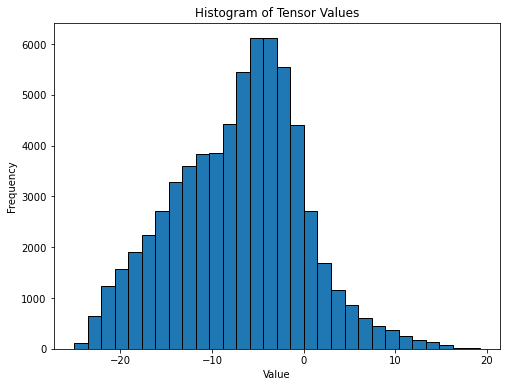

In [ ]:
t = t.flatten()
num_bins = 30
hist = torch.histc(t, bins=num_bins, min=torch.min(t).item(), max=torch.max(t).item())

# Define the edges of the bins
bin_edges = torch.linspace(torch.min(t).item(), torch.max(t).item(), steps=num_bins + 1)

# Plot the histogram using Matplotlib
plt.figure(figsize=(8, 6))
plt.hist(t.numpy(), bins=bin_edges.numpy(), edgecolor='black')
plt.title('Histogram of Tensor Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Integration heatmap

In [ ]:
inte = ns.scores[layername_best_semantic].squeeze()

# plot only highest integrating nodes
with PdfPages('integration heatmap semantic img0 best.pdf') as pdf:
    for vertical_slice in inte:
        sns.heatmap(vertical_slice)
        pdf.savefig()
        plt.close() 

## Permutation testing

Repeat analysis for randomly shuffeled integration values

In [204]:

integration = integration.squeeze(0)
integration.shape

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [205]:
integration_pt = torch.tensor(integration)

In [207]:
integration_pt.nelement()

49784

In [209]:
integration_randomized = integration_pt[torch.randperm(integration_pt.nelement())]

In [212]:
integration.shape

(49784,)

In [213]:
integration_randomized.shape

torch.Size([49784])

In [217]:
ns = NetworkScorer(activation_shapes)
ns.map_back_scores(integration_randomized.unsqueeze(0), pat_s)


In [218]:
# plot random pattern heatmaps for visual comparison
# TODO generate permutation distribution
with PdfPages('integration heatmap random scores.pdf') as pdf:
    for vertical_slice in ns.scores[layername_best_semantic]:
        sns.heatmap(vertical_slice)
        pdf.savefig()
        plt.close() 

In [49]:
activation_shapes["layer2.3.conv1"]

torch.Size([1, 128, 32, 32])

## Are integration beauty scores meaningfull ?

- Do the top nodes integration predict beauty better than the bottom nodes (or any other random 10%) ? \
- Use spatially coherent subsets to calculate scores.

---

## (old) random pattern scoring

In [ ]:
def run_singlelayer_analysis(dataset, activation_extractor, num_subsets, frac):
    num_layers = 1 # only take activations of best performing layer from each net
    num_images = dataset.img_count

    # get shapes of activation
    dummy_image = next(iter(dataset))
    net_activation = activation_extractor(dummy_image[0])
    net_activation = OrderedDict(net_activation)
    activation_shapes = taskonomy_activation_layer_shapes(net_activation)
    
    pat = Pattern_Generator(
        num_subsets,
        activation_shapes,
        frac=frac
        )

    # layer x image x subset
    integration = np.full([num_layers,num_images,num_subsets], np.nan, dtype=np.float64)
    cnt = 0

    # iterate image set
    for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
        if cnt % 30 == 0: print(cnt, end= ' ')
        cnt=cnt+1
        
        act_full = Activation_Pattern(activation_extractor(img_full))
        act_v1 = Activation_Pattern(activation_extractor(img_v1))
        act_v2 = Activation_Pattern(activation_extractor(img_v2))
        act_avg = Activation_Pattern.average(act_v1, act_v2)

        # iterate node subsets
        for subset_num in range(num_subsets):
            subset_mask = pat.get_subset_pattern(subset_num)
            
            subset_act_full = act_full[subset_mask]
            subset_act_avg = act_avg[subset_mask]

            # calculate integration and store it
            subset_integration = Activation_Pattern.calculate_integration_coeff(subset_act_full, subset_act_avg)
            integration[:,img_id, subset_num] = subset_integration
    
    ns = NetworkScorer(activation_shapes)
    ns.map_back_scores(integration, pat)

    return integration, ns

In [ ]:
num_subsets = 10000
# run analysis for semantic
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_semantic.scale))

integration_semantic_frac01, ns_semantic_frac01 = run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.01
    )

integration_semantic_frac10, ns_semantic_frac10 = run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.10
    )

integration_semantic_frac90, ns_semantic_frac90= run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.90
    )

0 30 60 90 120 150 180 210 240 

In [ ]:
integration_semantic_frac01.shape, ns_semantic_frac01.scores['layer3.4.conv2'].shape

((1, 250, 1), torch.Size([1, 256, 16, 16]))

In [ ]:
type(integration_semantic_frac01), type(ns_semantic_frac01.scores['layer3.4.conv2'])

(numpy.ndarray, torch.Tensor)

In [ ]:
num_subsets = 10000

# run analysis for semantic
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_semantic.scale))

integration_semantic_frac01, ns_semantic_frac01 = run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.01
    )

integration_semantic_frac10, ns_semantic_frac10 = run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.10
    )

integration_semantic_frac90, ns_semantic_frac90= run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.90
    )

# run analysis for 2d
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_2d.scale))

integration_2d_frac01, ns_2d_frac01 = run_singlelayer_analysis(
    dataset,
    activation_extractor_2d,
    num_subsets,
    frac=0.01
    )

integration_2d_frac10, ns_2d_frac10 = run_singlelayer_analysis(
    dataset,
    activation_extractor_2d,
    num_subsets,
    frac=0.10
    )

integration_2d_frac90, ns_2d_frac90= run_singlelayer_analysis(
    dataset,
    activation_extractor_2d,
    num_subsets,
    frac=0.90
    )

# run analysis for 3d
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_3d.scale))

integration_3d_frac01, ns_3d_frac01 = run_singlelayer_analysis(
    dataset,
    activation_extractor_3d,
    num_subsets,
    frac=0.01
    )

integration_3d_frac10, ns_3d_frac10 = run_singlelayer_analysis(
    dataset,
    activation_extractor_3d,
    num_subsets,
    frac=0.10
    )

integration_3d_frac90, ns_3d_frac90= run_singlelayer_analysis(
    dataset,
    activation_extractor_3d,
    num_subsets,
    frac=0.90
    )

0 30 60 90 120 150 180 210 240 0 30 60 90 120 150 180 210 240 0 30 60 90 120 150 180 210 240 0 30 60 90 120 150 180 210 240 0 30 60 90 120 150 180 210 240 0 30 60 90 120 150 180 210 240 0 30 60 90 120 150 180 210 240 0 30 60 90 120 150 180 210 240 0 30 60 90 120 150 180 210 240 

### save results

In [ ]:
FOLDER_SINGLELAYER_ANALYSIS = './analysis results singlelayer'

In [ ]:
from itertools import product
files_i = ["integration"+netclass+fracsize+".npy"
           for netclass, fracsize
           in product(["_semantic","_2d","_3d"], ["_frac01","_frac10","_frac90"])]
files_i

['integration_semantic_frac01.npy',
 'integration_semantic_frac10.npy',
 'integration_semantic_frac90.npy',
 'integration_2d_frac01.npy',
 'integration_2d_frac10.npy',
 'integration_2d_frac90.npy',
 'integration_3d_frac01.npy',
 'integration_3d_frac10.npy',
 'integration_3d_frac90.npy']

In [ ]:
files_n = ["integration"+netclass+fracsize+".pkl"
           for netclass, fracsize
           in product(["_semantic","_2d","_3d"], ["_frac01","_frac10","_frac90"])]
files_n

['integration_semantic_frac01.pkl',
 'integration_semantic_frac10.pkl',
 'integration_semantic_frac90.pkl',
 'integration_2d_frac01.pkl',
 'integration_2d_frac10.pkl',
 'integration_2d_frac90.pkl',
 'integration_3d_frac01.pkl',
 'integration_3d_frac10.pkl',
 'integration_3d_frac90.pkl']

In [ ]:
arrays_integration = [integration_semantic_frac01, integration_semantic_frac10, integration_semantic_frac90,
                      integration_2d_frac01, integration_2d_frac10, integration_2d_frac90,
                      integration_3d_frac01, integration_3d_frac10, integration_3d_frac90]

objects_nodescoring = [ns_semantic_frac01, ns_semantic_frac10, ns_semantic_frac90,
                       ns_2d_frac01, ns_2d_frac10, ns_2d_frac90,
                       ns_3d_frac01, ns_3d_frac10, ns_3d_frac90]

In [ ]:
for file_i, file_n, array_i, array_n in zip(files_i, files_n, arrays_integration, objects_nodescoring):
    with open(os.path.join(FOLDER_SINGLELAYER_ANALYSIS, file_i), "wb") as f1:
        np.save(f1, array_i)
    
    with open(os.path.join(FOLDER_SINGLELAYER_ANALYSIS, file_n), "wb") as f2:
        pickle.dump(array_n, f2)


### load results

## (old) manipulating integratability and watch response of network



gradually perform image transformations shown to break integration to:
- test where in the network integration takes place
- test whether different manipulations break different clusters first



Do integration beauty scoring with node pools sweeping along 3D axis
- full width 2D layer pools along all three axis
- 3D cubic pool along all three axis (vary in size)

permutation test for integration: generate permutation distribution by calculating integration at each location in the layer to random input. input real image, calculate clusters of significant integration.

Do semantic / 2d / 3d nets integrate different features (semantic vs structural) or are they essentially integrating the same features but in a different way ?

Do different manipulations break integration in different ways ?
Look at:
    a) How much manipulation does is need to break integration ?
    b) In which networks / layers / scales / datasets is integration broken in which order ?
    c) Which image's integration is broken first ?


Collect different ways of manipulating images to break integration.
    - Do these
    a) all break integration the same way
    b) cluster into groups in the way in which they break integration


### pixelated images

In [ ]:
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_semantic.scale))
it_dataset = iter(dataset)

im = next(it_dataset)[0].squeeze()
im2 = next(it_dataset)[2].squeeze()

In [ ]:
im.min(), im.max(), im2.min(), im2.max()

(tensor(-1.0459), tensor(0.9453), tensor(-0.9814), tensor(1.0543))

In [ ]:
im = im + im.min().abs()
im = im / im.max()
#d2 = 1-d2
im.min(), im.max()

(tensor(0.), tensor(1.))

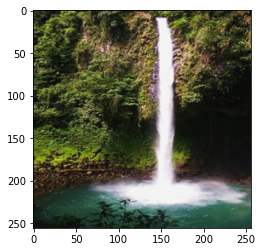

In [ ]:
plt.imshow(im.permute(1,2,0))

In [ ]:
im2

tensor([[[ 0.0276,  0.1295,  0.2838,  ..., -0.0039, -0.0039, -0.0039],
         [ 0.0917, -0.0922, -0.0534,  ..., -0.0039, -0.0039, -0.0039],
         [ 0.1930,  0.0019, -0.1224,  ..., -0.0039, -0.0039, -0.0039],
         ...,
         [-0.0039, -0.0039, -0.0039,  ...,  0.2050, -0.0175, -0.0391],
         [-0.0039, -0.0039, -0.0039,  ...,  0.1220,  0.0201,  0.0290],
         [-0.0039, -0.0039, -0.0039,  ...,  0.1787,  0.1376,  0.0437]],

        [[-0.0566,  0.1199,  0.3565,  ..., -0.0039, -0.0039, -0.0039],
         [ 0.0319, -0.0759,  0.0399,  ..., -0.0039, -0.0039, -0.0039],
         [ 0.1818,  0.0487, -0.0075,  ..., -0.0039, -0.0039, -0.0039],
         ...,
         [-0.0039, -0.0039, -0.0039,  ...,  0.2027,  0.0274,  0.0592],
         [-0.0039, -0.0039, -0.0039,  ...,  0.1741,  0.0895,  0.1379],
         [-0.0039, -0.0039, -0.0039,  ...,  0.2479,  0.2227,  0.1666]],

        [[-0.2608, -0.1759, -0.0521,  ..., -0.0039, -0.0039, -0.0039],
         [-0.2006, -0.3853, -0.3720,  ..., -0

In [ ]:
# take a fraction of the pixels on the 256x256 grid and permute them
pix_degree = 0.5

In [ ]:
mask_pix = torch.rand((256,256)) < pix_degree
mask_original = ~mask_pix

# number of pixels that are pixeled, this is not exactly the pix degree due to randomness
n_pix = im[:,mask_pix].shape[1] 


In [ ]:
pix_im = torch.full_like(im, np.nan)

# non-pixeled part
pix_im[:,mask_original] = im[:,mask_original]

# pixeled part
pix_im[:,mask_pix] = im[:,mask_pix][:,torch.randperm(n_pix)]

In [ ]:
def pixelate_image(im, pix_degree: float):
    """ Pixelate a 256x256 image"""
    mask_pix = torch.rand((256,256)) < pix_degree
    mask_original = ~mask_pix

    # number of pixels that are pixeled, this is not exactly the pix degree due to randomness
    n_pix = im[:,mask_pix].shape[1] 

    pix_im = torch.full_like(im, np.nan)

    # non-pixeled part
    pix_im[:,mask_original] = im[:,mask_original]

    # pixeled part
    pix_im[:,mask_pix] = im[:,mask_pix][:,torch.randperm(n_pix)]

    return pix_im


In [ ]:
def img_print(im):
    im = im + im.min().abs()
    im = im / im.max()
    plt.imshow(im.permute(1,2,0))

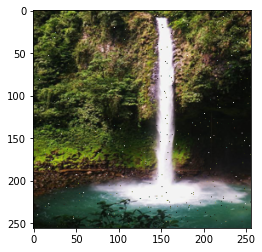

In [ ]:
img_print(pixelate_image(im, 0.01))

In [ ]:
# TODO: since at 0.25 theres already a strong (subjective) visual disturbance,
# maybe apply a logarithmic scale with image pixelation

In [ ]:
# TODO: as annother gradual transformation, implement a gradual low-pass filter

### imageversions

In [ ]:
256 / 32

8.0

In [ ]:
im.dtype

torch.float32

In [ ]:
torch.tensor(127/127.5-1, dtype=torch.float32)

tensor(-0.0039)

In [ ]:
torch.tensor([[1,0],[0,1]]).repeat_interleave(2,dim=0).repeat_interleave(2,dim=1)

tensor([[1, 1, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 1],
        [0, 0, 1, 1]])

In [ ]:
def create_checkerboard(scale, size=256):
    msc = torch.tensor([[1, 0] * (scale//2), [0, 1] * (scale//2)] * (scale//2))
    return msc.repeat_interleave(size//scale, dim=0).repeat_interleave(size//scale, dim=1)

In [ ]:
create_checkerboard(64).shape

torch.Size([256, 256])

### get activations for pixelated images

In [ ]:
act_full 

In [ ]:
activation_extractor_semantic().keys()

dict_keys(['layer3.4.conv2'])

In [ ]:
activation_extractor_semantic(torch.rand_like(dummy_image[0]))['layer3.4.conv2'].shape

torch.Size([1, 256, 16, 16])

###  get distribution of integration / ib-correlation of random images

In [ ]:
dummy_image[1]

tensor([[[[-0.0039, -0.0039, -0.0039,  ...,  0.0685, -0.0562,  0.0665],
          [-0.0039, -0.0039, -0.0039,  ..., -0.1197, -0.5539, -0.5943],
          [-0.0039, -0.0039, -0.0039,  ...,  0.0115, -0.7670, -0.8672],
          ...,
          [-0.9604, -0.9617, -0.9620,  ..., -0.0039, -0.0039, -0.0039],
          [-0.9573, -0.9499, -0.9297,  ..., -0.0039, -0.0039, -0.0039],
          [-0.9410, -0.9451, -0.9363,  ..., -0.0039, -0.0039, -0.0039]],

         [[-0.0039, -0.0039, -0.0039,  ..., -0.2645, -0.3533, -0.1753],
          [-0.0039, -0.0039, -0.0039,  ..., -0.4042, -0.7878, -0.7646],
          [-0.0039, -0.0039, -0.0039,  ..., -0.1939, -0.9149, -0.9395],
          ...,
          [-0.9212, -0.9226, -0.9228,  ..., -0.0039, -0.0039, -0.0039],
          [-0.9172, -0.9092, -0.8900,  ..., -0.0039, -0.0039, -0.0039],
          [-0.8945, -0.8980, -0.8902,  ..., -0.0039, -0.0039, -0.0039]],

         [[-0.0039, -0.0039, -0.0039,  ..., -0.5420, -0.5460, -0.3211],
          [-0.0039, -0.0039, -

In [ ]:
# for each image
ac = activation_extractor_semantic(torch.rand_like(dummy_image[0]))['layer3.4.conv2']
ac = ac.squeeze()
ac.shape

torch.Size([256, 16, 16])

### get previous one at each location

In [ ]:
for l1, l2 in zip(ac_full, ac_avg):
    pass

In [ ]:
l1.shape

torch.Size([16, 16])

### visual inspection
are there maybe any clusters of integration to random images, already revealing a integration structure in the network

### get activation of actual image

### test where there are significant clusters of integration